# Help, the solver crashed!

The previous tutorials have mostly used simple input data where we can rely on Firedrake's built-in numerical solvers to work on the first try.
One exception to this was in the Larsen C notebook.
The remote sensing data that we used for the thickness were finely resolved to capture individual rifts, which look like discontinuities.
A discontinuity makes the slope, and in turn the driving stress, go to infinity.
This singularity will break a numerical solver.
The remedy was to smooth over the ice thickness a bit.

Realistic problems can require some finesse to solve.
Although it might seem that synthetic problems are easier, sometimes the opposite is true.
A real glacier has got itself somewhere kind of near equilibrium for you and spent a few decades doing it.
If you make up a synthetic bed geometry and thickness, there isn't an obvious way to guess what velocity solves the momentum balance equation.
The Newton-type methods that we use are, in principle, supposed to converge from any initial guess.
But the rate of convergence is hard to guess at when you start far from the true solution.

This tutorial will show a test case where we might have to make some choices about what method to use.
We'll take a standard test case, try to solve the diagnostic equations, and fail (at first).
Then we'll look at how to get more information about the failure mode.
Some failure modes are easier to recover from than others.
Finally, we'll show some different solver options that we can use to recover from convergence failures.

Here we'll look at the MISMIP+ test case, described in [Asay-Davis et al. (2016)](https://doi.org/10.5194/gmd-9-2471-2016).
MISMIP+ is a standard test problem for evaluating glaciological flow models and we'll revisit it again in the guides that follow.

In [1]:
import firedrake
from firedrake import (
    sqrt, exp, max_value, inner, as_vector, Constant, Function, dx
)

Lx, Ly = 640e3, 80e3
ny = 20
nx = int(Lx / Ly) * ny
area = Lx * Ly

mesh = firedrake.RectangleMesh(nx, ny, Lx, Ly)
Q = firedrake.FunctionSpace(mesh, "CG", 1)
V = firedrake.VectorFunctionSpace(mesh, "CG", 1)

/home/firedrake/firedrake/lib/python3.12/site-packages/pytools/persistent_dict.py:52: RecommendedHashNotFoundWarning: Unable to import recommended hash 'siphash24.siphash13', falling back to 'hashlib.sha256'. Run 'python3 -m pip install siphash24' to install the recommended hash.
  warn("Unable to import recommended hash 'siphash24.siphash13', "


The MISMIP+ experimental protocol defines a profile for the ice bed that is a 6th-order polynomial in $x$ and an exponential in $y$.
The bed shape was designed to create a bench or bedrock high in the $x$ direction that the ice could ground on and, given enough of a meltwater kick, to retreat off of.
The shape in the $y$ direction is designed to funnel ice off of the side walls and create geometric constrictions.

In [2]:
x, y = firedrake.SpatialCoordinate(mesh)

x_c = Constant(300e3)
X = x / x_c

B_0 = Constant(-150)
B_2 = Constant(-728.8)
B_4 = Constant(343.91)
B_6 = Constant(-50.57)
B_x = B_0 + B_2 * X**2 + B_4 * X**4 + B_6 * X**6

f_c = Constant(4e3)
d_c = Constant(500)
w_c = Constant(24e3)

B_y = d_c * (
    1 / (1 + exp(-2 * (y - Ly / 2 - w_c) / f_c)) +
    1 / (1 + exp(+2 * (y - Ly / 2 + w_c) / f_c))
)

z_deep = Constant(-720)
z_b = Function(Q).interpolate(max_value(B_x + B_y, z_deep))

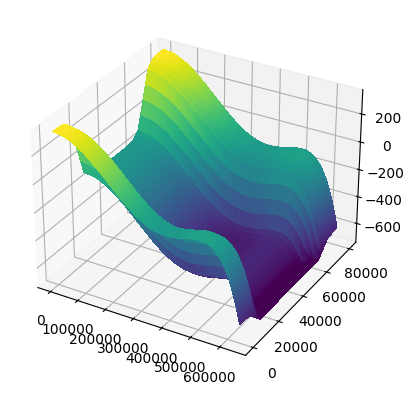

In [3]:
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

fig = plt.figure()
axes = fig.add_subplot(projection="3d")
firedrake.trisurf(z_b, axes=axes);

The experiment further sets the default values for the ice fluidity and friction, but leaves it to modelers to set the exact friction law.
We'll use our form of the Schoof sliding law from the tutorials on ice streams rather than the Weertman sliding law.
This sliding law crucially includes a ramping factor that smoothly dials the friction down towards the grounding line.
Without this ramping factor, the system would experience a sudden shock across the grounding line, which often manifests in numerical artifacts.

In [4]:
A = Constant(20)
C = Constant(1e-2)

In [5]:
from icepack.constants import (
    ice_density as ρ_I,
    water_density as ρ_W,
    gravity as g,
    glen_flow_law as n,
    weertman_sliding_law as m,
)

def friction(**kwargs):
    variables = ("velocity", "thickness", "surface", "friction")
    u, h, s, C = map(kwargs.get, variables)

    p_W = ρ_W * g * max_value(0, -(s - h))
    p_I = ρ_I * g * h
    N = max_value(0, p_I - p_W)
    τ_c = N / 2

    u_c = (τ_c / C)**m
    u_b = sqrt(inner(u, u))

    return τ_c * (
        (u_c**(1 / m + 1) + u_b**(1 / m + 1))**(m / (m + 1)) - u_c
    )

The experiment specifies an accumulation rate of 30 cm / year in the initial spin-up phase.
In later guides we'll look at the next phase of the experiment, which uses a pre-defined function of the depth below the water line to set sub-ice shelf melt rate.

In [6]:
a = Constant(0.3)

For now, we'll focus on the 2D ice stream model, which is more than enough to illustrate the different kinds of solver options you can choose.
Comparing the results with those of the hybrid model is a worthwhile exercise though -- it tells us the degree to which resolving vertical shear is important for the problem we're solving.

In [7]:
import icepack

model = icepack.models.IceStream(friction=friction)

We can't predict ahead of time what the steady state thickness of the ice stream will be.
The purpose of the exercise is to start from a physically unrealistic starting state -- a constant thickness of 100m everywhere -- and spin this up to steady state.
Starting so far from the true solution is a hard stress test for the solver.
As we'll see, it doesn't always pass.

In [8]:
h = Function(Q).assign(Constant(100))
s = icepack.compute_surface(thickness=h, bed=z_b)

δu = Constant(90)
u_guess = Function(V).interpolate(as_vector((δu * x / Lx, 0)))

Here we've wrapped the diagnostic solve call in a try/except block because we have reason to believe that it might fail.

In [9]:
opts = {"dirichlet_ids": [1], "side_wall_ids": [3, 4]}
solver = icepack.solvers.FlowSolver(model, **opts)

fields = {
    "velocity": u_guess,
    "thickness": h,
    "surface": s,
    "fluidity": A,
    "friction": C,
}

try:
    solver.diagnostic_solve(**fields)
except firedrake.ConvergenceError as error:
    print(error)

Nonlinear solve failed to converge after 50 nonlinear iterations.
Reason:
   DIVERGED_MAX_IT


With the default options, the solver didn't converge after 50 iterations.
This error message alone isn't enough to debug what's going wrong.
We can get more information by telling PETSc to print out some diagnostic information about the outer-level nonlinear solve.

In [10]:
opts = {
    "dirichlet_ids": [1],
    "side_wall_ids": [3, 4],
    "diagnostic_solver_parameters": {"snes_monitor": None},
}

When we call the diagnostic solve routine again, we'll get an unholy mess of text output.
If you parse through all of this you can see that the residual norm went from $10^7$ monotonically down to $10^5$ after 50 iterations.

In [11]:
solver = icepack.solvers.FlowSolver(model, **opts)
try:
    solver.diagnostic_solve(**fields)
except firedrake.ConvergenceError as error:
    print(error)

  0 SNES Function norm 1.194080635257e+07


  1 SNES Function norm 5.480577373167e+06
  2 SNES Function norm 5.647080148201e+06


  3 SNES Function norm 5.475457080921e+06
  4 SNES Function norm 5.395947242374e+06


  5 SNES Function norm 5.325603796412e+06
  6 SNES Function norm 5.255728041832e+06


  7 SNES Function norm 5.185563042411e+06


  8 SNES Function norm 5.115038691794e+06
  9 SNES Function norm 5.044144524186e+06


 10 SNES Function norm 4.972877116932e+06


 11 SNES Function norm 4.901233051883e+06
 12 SNES Function norm 4.829204138000e+06


 13 SNES Function norm 4.756767033025e+06


 14 SNES Function norm 4.683872373464e+06
 15 SNES Function norm 4.610443892275e+06


 16 SNES Function norm 4.536396639772e+06
 17 SNES Function norm 4.461677318032e+06


 18 SNES Function norm 4.386312090508e+06
 19 SNES Function norm 4.310390499966e+06


 20 SNES Function norm 4.233945487049e+06
 21 SNES Function norm 4.156893939679e+06


 22 SNES Function norm 4.079178488317e+06
 23 SNES Function norm 4.001045306745e+06


 24 SNES Function norm 3.923381604826e+06


 25 SNES Function norm 3.847543556770e+06
 26 SNES Function norm 3.773507891812e+06


 27 SNES Function norm 3.697208807850e+06


 28 SNES Function norm 2.254802077992e+06
 29 SNES Function norm 1.705453423110e+06
 30 SNES Function norm 2.487374445257e+06


 31 SNES Function norm 2.538577968160e+06


 32 SNES Function norm 2.316657676231e+06
 33 SNES Function norm 2.126894258051e+06
 34 SNES Function norm 1.994281615756e+06


 35 SNES Function norm 1.894733543640e+06


 36 SNES Function norm 8.431789817564e+05
 37 SNES Function norm 1.555118234017e+06
 38 SNES Function norm 7.151557168747e+05


 39 SNES Function norm 5.069806973716e+05


 40 SNES Function norm 3.258508351032e+05
 41 SNES Function norm 7.280287479400e+05


 42 SNES Function norm 3.975975753663e+05
 43 SNES Function norm 3.298258007234e+05


 44 SNES Function norm 2.437827234215e+05
 45 SNES Function norm 1.846270127212e+05


 46 SNES Function norm 1.381000318646e+05


 47 SNES Function norm 7.158492916430e+04
 48 SNES Function norm 2.565813911597e+04
 49 SNES Function norm 3.099976556521e+03


 50 SNES Function norm 2.415309034863e+02
Nonlinear solve failed to converge after 50 nonlinear iterations.
Reason:
   DIVERGED_MAX_IT


The average glaciologist should never have to mess with this, but it's better to know how and not need it.
For good measure let's try all of the other line search methods that are available in PETSc.
These are:
* `"basic"`: take the full Newton step; no line search at all
* `"bt"`: backtracking; try the full step, and walk back if it's no good
* `"l2"`: minimize the residual along the search direction using cubic fitting
* `"cp"`: assume that the nonlinear equation to be solved is really finding a critical point of some scalar functional
* `"nleqerr"`: this is the default in icepack; uses what are called affine-covariant methods, described in [this book](https://doi.org/10.1007/978-3-642-23899-4) which haunts my dreams

In [12]:
for line_search_type in ["basic", "bt", "l2", "cp", "nleqerr"]:
    opts = {
        "dirichlet_ids": [1],
        "side_wall_ids": [3, 4],
        "diagnostic_solver_parameters": {
            "snes_linesearch_type": line_search_type,
        },
    }
    solver = icepack.solvers.FlowSolver(model, **opts)
    try:
        u_0 = solver.diagnostic_solve(**fields)
        print(f"Method {line_search_type} worked!")
    except firedrake.ConvergenceError as error:
        message = str(error).replace("\n", " ")
        print(f"Method {line_search_type} failed with: {message}")

Method basic failed with: Nonlinear solve failed to converge after 37 nonlinear iterations. Reason:    DIVERGED_DTOL


Method bt worked!


Method l2 worked!


Method cp failed with: Nonlinear solve failed to converge after 50 nonlinear iterations. Reason:    DIVERGED_MAX_IT


Method nleqerr failed with: Nonlinear solve failed to converge after 50 nonlinear iterations. Reason:    DIVERGED_MAX_IT


Using no line search at all made the solver diverge -- the residual norm was increasing instead of decreasing.
Both backtracking and cubic line search worked.
The critical point and affine-covariant methods took too long.
We could stop here and just use one of the methods that worked (`bt` and `l2`).
This feels a little hacky but if you're desparate it can work in a pinch.

Instead, let's remember what happened when we used the default `nleqerr` method -- the residual was decreasing monotonically, but slowly.
What if we instead budgeted for more iterations?

In [13]:
opts = {
    "dirichlet_ids": [1],
    "side_wall_ids": [3, 4],
    "diagnostic_solver_parameters": {
        "snes_monitor": None,
        "snes_linesearch_type": "nleqerr",
        "snes_max_it": 200,
    },
}
solver = icepack.solvers.FlowSolver(model, **opts)
u_0 = solver.diagnostic_solve(**fields)

  0 SNES Function norm 1.194080635257e+07


  1 SNES Function norm 5.480577373167e+06
  2 SNES Function norm 5.647080148201e+06
  3 SNES Function norm 5.475457080921e+06


  4 SNES Function norm 5.395947242374e+06


  5 SNES Function norm 5.325603796412e+06
  6 SNES Function norm 5.255728041832e+06
  7 SNES Function norm 5.185563042411e+06


  8 SNES Function norm 5.115038691794e+06


  9 SNES Function norm 5.044144524186e+06
 10 SNES Function norm 4.972877116932e+06
 11 SNES Function norm 4.901233051883e+06


 12 SNES Function norm 4.829204138000e+06


 13 SNES Function norm 4.756767033025e+06
 14 SNES Function norm 4.683872373464e+06
 15 SNES Function norm 4.610443892275e+06


 16 SNES Function norm 4.536396639772e+06
 17 SNES Function norm 4.461677318032e+06
 18 SNES Function norm 4.386312090508e+06
 19 SNES Function norm 4.310390499966e+06


 20 SNES Function norm 4.233945487049e+06
 21 SNES Function norm 4.156893939679e+06
 22 SNES Function norm 4.079178488317e+06


 23 SNES Function norm 4.001045306745e+06
 24 SNES Function norm 3.923381604826e+06
 25 SNES Function norm 3.847543556770e+06
 26 SNES Function norm 3.773507891812e+06


 27 SNES Function norm 3.697208807850e+06
 28 SNES Function norm 2.254802077992e+06
 29 SNES Function norm 1.705453423110e+06
 30 SNES Function norm 2.487374445257e+06


 31 SNES Function norm 2.538577968160e+06
 32 SNES Function norm 2.316657676231e+06
 33 SNES Function norm 2.126894258051e+06
 34 SNES Function norm 1.994281615756e+06


 35 SNES Function norm 1.894733543640e+06
 36 SNES Function norm 8.431789817564e+05
 37 SNES Function norm 1.555118234017e+06
 38 SNES Function norm 7.151557168747e+05


 39 SNES Function norm 5.069806973716e+05
 40 SNES Function norm 3.258508351032e+05
 41 SNES Function norm 7.280287479400e+05
 42 SNES Function norm 3.975975753663e+05


 43 SNES Function norm 3.298258007234e+05
 44 SNES Function norm 2.437827234215e+05
 45 SNES Function norm 1.846270127212e+05
 46 SNES Function norm 1.381000318646e+05


 47 SNES Function norm 7.158492916430e+04
 48 SNES Function norm 2.565813911597e+04
 49 SNES Function norm 3.099976556521e+03
 50 SNES Function norm 2.415309034863e+02


 51 SNES Function norm 3.675214029522e+00
 52 SNES Function norm 5.634625354447e-07


The solver converged, it just took a few more iterations than our initial maximum of 50.

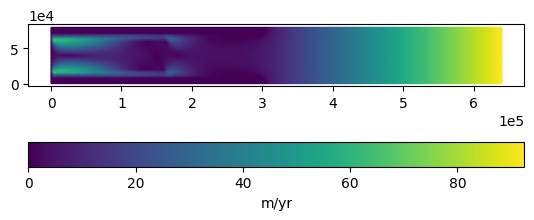

In [14]:
import icepack.plot

fig, ax = icepack.plot.subplots()
colors = firedrake.tripcolor(u_0, axes=ax)
fig.colorbar(colors, label="m/yr", orientation="horizontal");

There's one final trick that's worth knowing.
The default nonlinear solver method in PETSc is based on Newton's method with a line search.
There's an alternative called a *trust region* method which works in a different way.
The trust region method can work better on some problems where the line search method fails or converges slowly.
To use a trust region method, we give a different argument for `"snes_type"` when we make the solver.

In [15]:
opts = {
    "dirichlet_ids": [1],
    "side_wall_ids": [3, 4],
    "diagnostic_solver_parameters": {
        "snes_monitor": None,
        "snes_type": "newtontr",
        "snes_max_it": 200,
    },
}
solver = icepack.solvers.FlowSolver(model, **opts)
u_0 = solver.diagnostic_solve(**fields)

  0 SNES Function norm 1.194080635257e+07
  1 SNES Function norm 1.193516881501e+07
  2 SNES Function norm 1.192732199665e+07


  3 SNES Function norm 1.200556082378e+07
  4 SNES Function norm 2.301782184043e+07
  5 SNES Function norm 2.300733429283e+07


  6 SNES Function norm 2.298630174769e+07
  7 SNES Function norm 2.294400491613e+07


  8 SNES Function norm 2.285846834629e+07
  9 SNES Function norm 2.268348906507e+07
 10 SNES Function norm 2.231668500066e+07


 11 SNES Function norm 2.150280106671e+07
 12 SNES Function norm 1.954590972955e+07
 13 SNES Function norm 1.352880133667e+07


 14 SNES Function norm 5.719870635666e+06
 15 SNES Function norm 3.477097341342e+06


 16 SNES Function norm 1.948905156717e+06
 17 SNES Function norm 9.924709855265e+05


 18 SNES Function norm 9.658342944338e+05
 19 SNES Function norm 8.967341520766e+05
 20 SNES Function norm 6.602149901037e+05


 21 SNES Function norm 5.013917783341e+05
 22 SNES Function norm 3.353252484062e+05


 23 SNES Function norm 3.053198165674e+05
 24 SNES Function norm 1.976509558503e+05


 25 SNES Function norm 1.543162696374e+05
 26 SNES Function norm 6.967138984325e+04
 27 SNES Function norm 1.880939685242e+04


 28 SNES Function norm 3.231351259296e+03
 29 SNES Function norm 4.838645509234e+02


 30 SNES Function norm 7.051910772154e+00
 31 SNES Function norm 1.475489825636e-03


## Recap

When the solver fails, try the following:
1. If the solver immediately fails with `DIVERGED_FNORM_NAN`, then there's some kind of division by zero error.
The most likely explanation is that the input data are bad -- a zero thickness, a discontinuity in the surface, etc.
No amount of fiddling with the solver can fix this error.
3. Add `"snes_monitor": None` to the solver options.
This will tell you how fast or catastrophically the solver is failing.
4. If you're desparate, you can also add add `"snes_linesearch_monitor": None`.
5. If the residual is decreasing but slowly, try increasing the maximum number of iterations.
6. Try all the possible line search methods.
7. Try using the Newton trust region method.
8. If all of these fail, [get in touch](https://icepack.github.io/contact/) with the complete script and data and output from SNES monitor.

In an ideal world, the solvers would all work perfectly the first time and you wouldn't need to know any of this.
We strive to make icepack as robust as it can be through both good defaults and careful problem formulation.
But you might still need some of the strategies outlined above.

The initial diagnostic solve to compute the starting velocity is usually the most challenging.
Provided that the timestep is not too large, the changes to the thickness should be small enough that the velocity from the previous timestep will be a good guess for the velocity at the next timestep.
When solving statistical estimation problems, on the other hand, the outer-level optimization solver can make weird or unphysical guesses for the parameters, which can then crash the inner-level physics solver.
Knowing how to get more information from PETSc using `"snes_monitor"` is crucial to debugging these types of problems.